In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from toolz import partial
from scipy.stats import entropy
from aging.plotting import format_plots, PlotConfig, save_factory, figure, legend, LONGTOGENY_AGE_CMAP

In [2]:
format_plots()
c = PlotConfig()
saver = save_factory(c.save_path / "longtogeny-characterization", tight_layout=False)

In [3]:
def load_long_df(version=5):
    usage_mtx = pd.read_parquet(
        f"/n/groups/datta/win/longtogeny/data/ontogeny/version_{version:02d}/longtogeny_males_clean.parquet"
    )
    return usage_mtx

In [17]:
df = load_long_df(version=5)
# df = df.query('age < 600')

keep_sylls = df.columns[df.median() > 0.005]
df = df[keep_sylls]

index = ['age', 'mouse', 'cage', 'uuid', 'subject_name', 'date']

index = ['binned_age'] + index
ages = df.index.get_level_values('age')
lbls, bins = pd.qcut(ages, 16, labels=False, retbins=True)

df['binned_age'] = lbls
df = df.reset_index().set_index(index)
binned_ages = df.groupby(['binned_age', 'mouse', 'cage']).mean()

In [18]:
entropy_df = (binned_ages + 1e-6).apply(entropy, axis=1)
entropy_df.name = 'entropy'
entropy_df = entropy_df.reset_index()

entropy_df["age"] = entropy_df["binned_age"].map(
    dict(enumerate((bins[:-1] + bins[1:]) / 2 / 7))
)

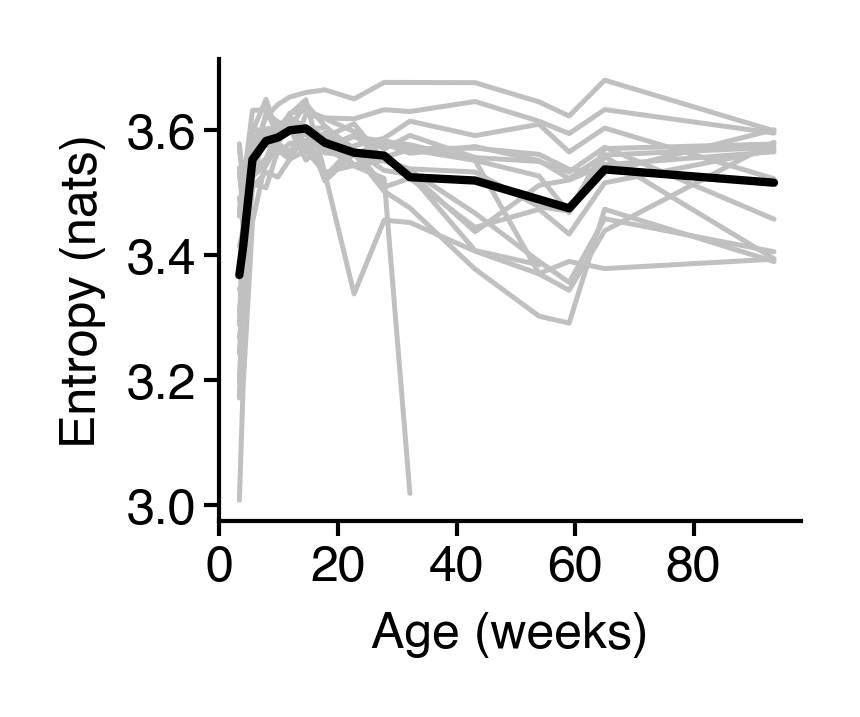

In [28]:
fig = figure(1.25, 1)
ax = sns.lineplot(
    data=entropy_df.reset_index(),
    x="age",
    y="entropy",
    errorbar="se",
    hue="mouse",
    legend=False,
    palette=['silver'] * 16,
    lw=0.6
)
ax = sns.lineplot(
    data=entropy_df.reset_index(),
    x="age",
    y="entropy",
    errorbar=None,
    color='k',
)
ax.locator_params(nbins=5, axis='x')
ax.set(xlabel="Age (weeks)", ylabel="Entropy (nats)", xlim=(0, None))
sns.despine()
saver(fig, "entropy-over-age-longtogeny");